In [1]:
using LinearAlgebra, CairoMakie

In [10]:
pars = (;α = 0.33, # Capital Share
        β = 0.9, # Discount Factor
        γ = 1.0, # CRRA Parameter
        δ = 0.1, # Depreciation Rate
        A = 2.0, # TFP
        grid_size = 101, # Capital Grid Size
        grid_min = 0.75, # Minimum Capital (multiple of steady state)
        grid_max = 1.25, # Maximum Capital (multiple of steady state)
        maxiter = 10000, # Max Iterations
        toler = 1e-6, # Tolerance
        m = 100) # Howard Iterations

(α = 0.33, β = 0.9, γ = 1.0, δ = 0.1, A = 2.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, maxiter = 10000, toler = 1.0e-6, m = 100)

In [11]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function utility_vec(c, pars)
    if pars.γ == 1
        return log.(c)
    else
        return (c.^(1-pars.γ))./(1-pars.γ)
    end
end

utility_vec (generic function with 1 method)

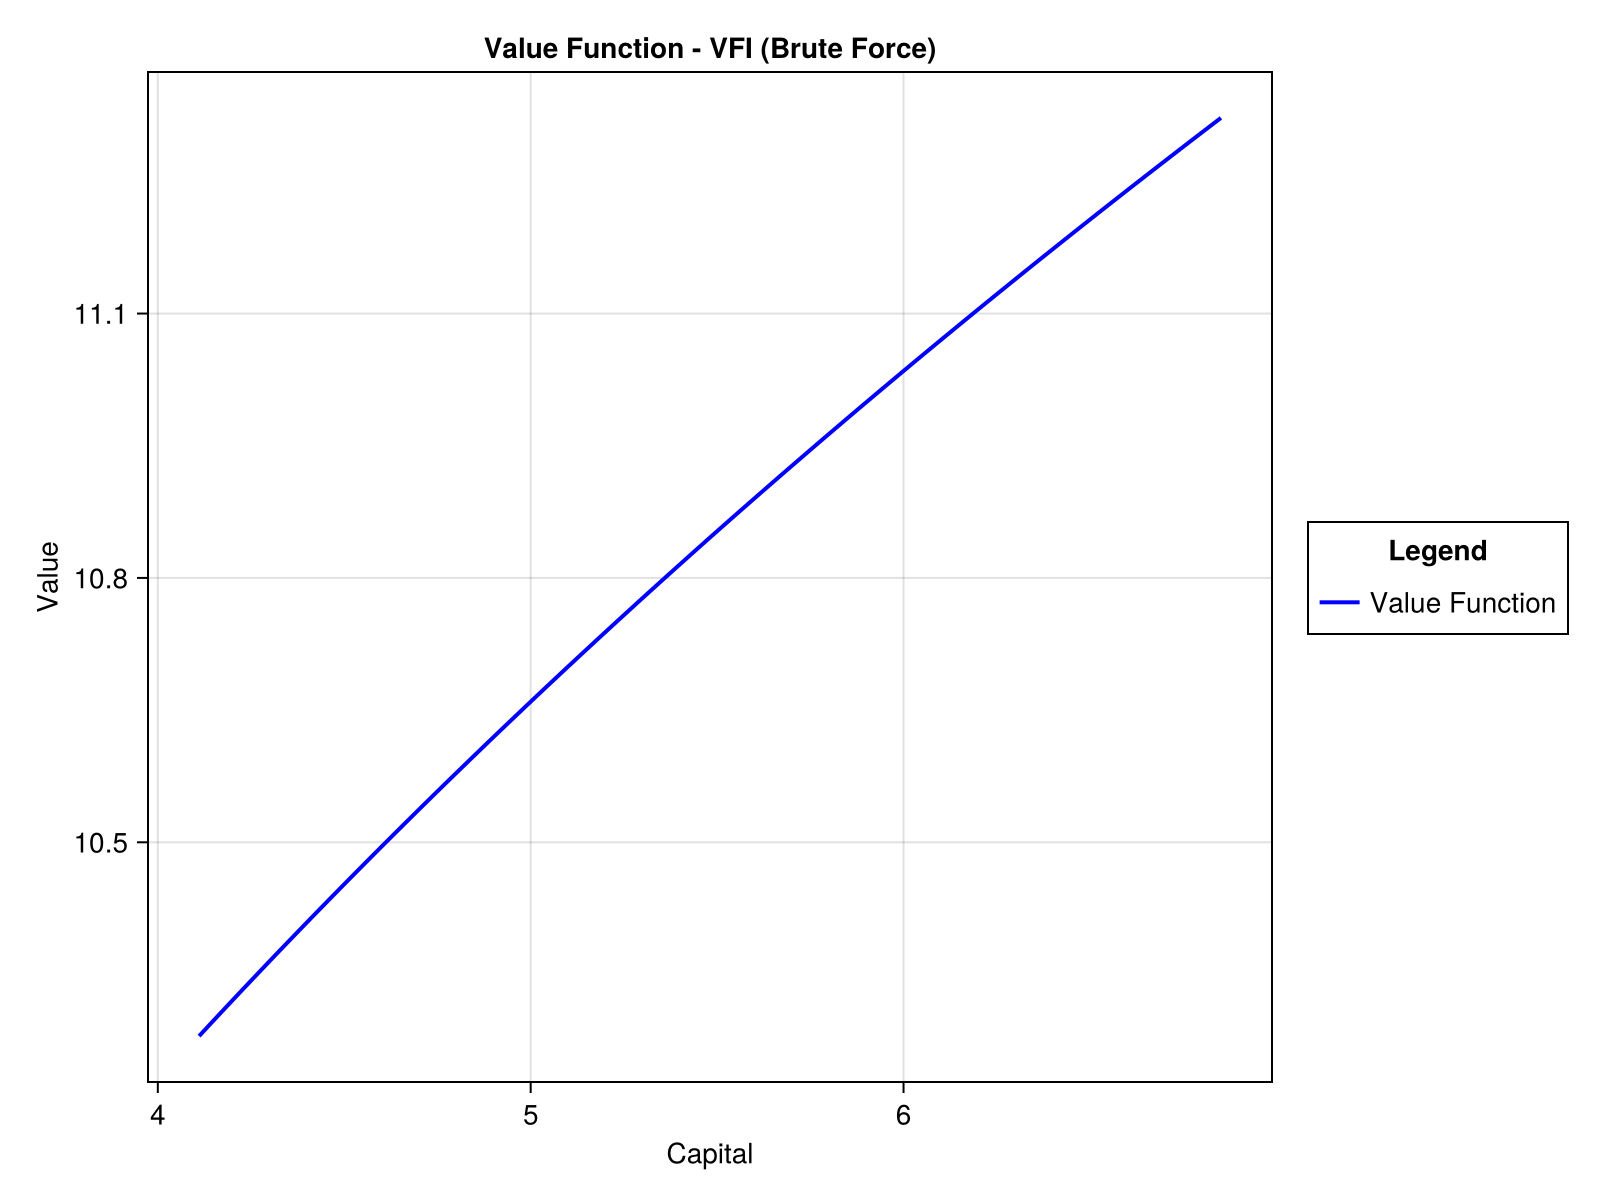

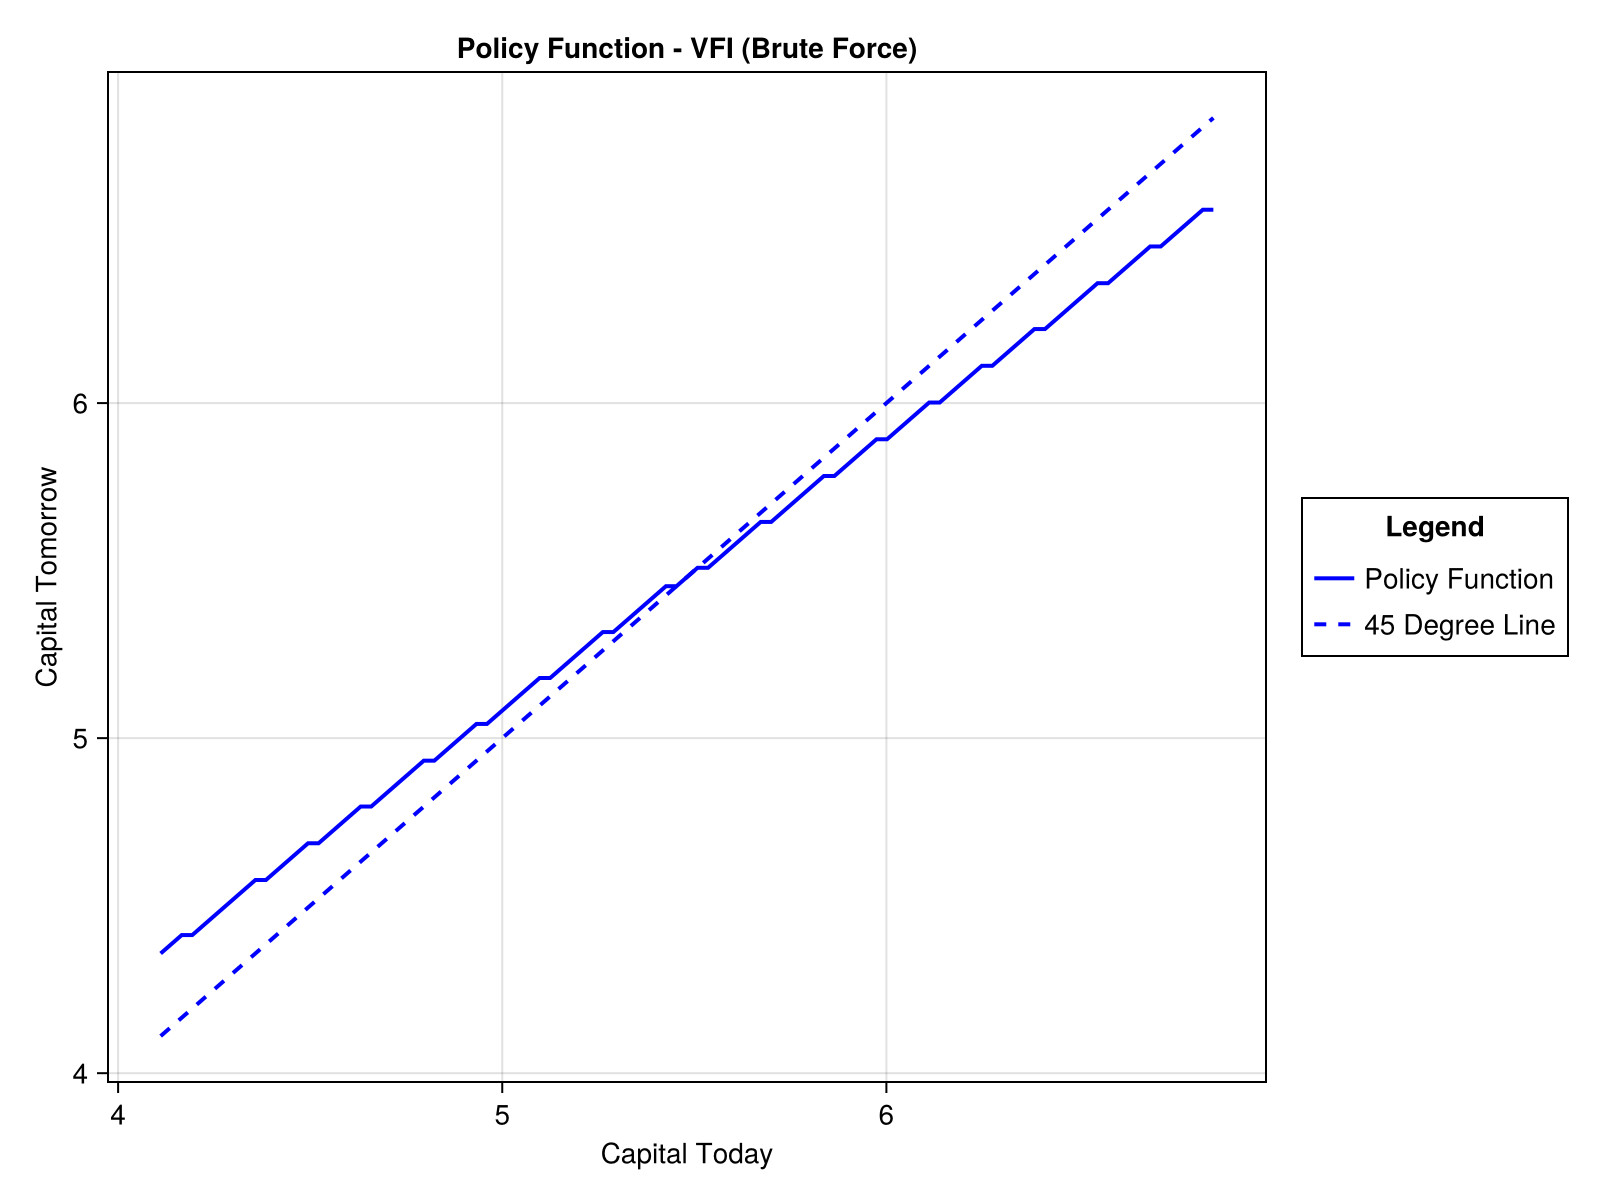

Iterating...
--------------------
iteration 0 completed with error 1.762951428590337
--------------------
converged in 133 iterations
--------------------
  0.672500 seconds (392.78 k allocations: 55.483 MiB, 1.54% gc time, 42.44% compilation time)


(Float32[10.2800865, 10.292588, 10.305016, 10.317384, 10.329702, 10.341964, 10.354178, 10.366338, 10.3784485, 10.390503  …  11.241433, 11.250481, 11.259505, 11.2685, 11.277481, 11.286443, 11.295381, 11.30428, 11.313158, 11.322014], Float32[4.3573465, 4.3847513, 4.412156, 4.412156, 4.439561, 4.4669657, 4.49437, 4.521775, 4.5491796, 4.5765843  …  6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.577127])

In [12]:
function vfi_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        error = maximum(dist)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_out_nt, pol_out_nt = vfi_nt_brute_force(zeros(pars.grid_size,1), pars)
end

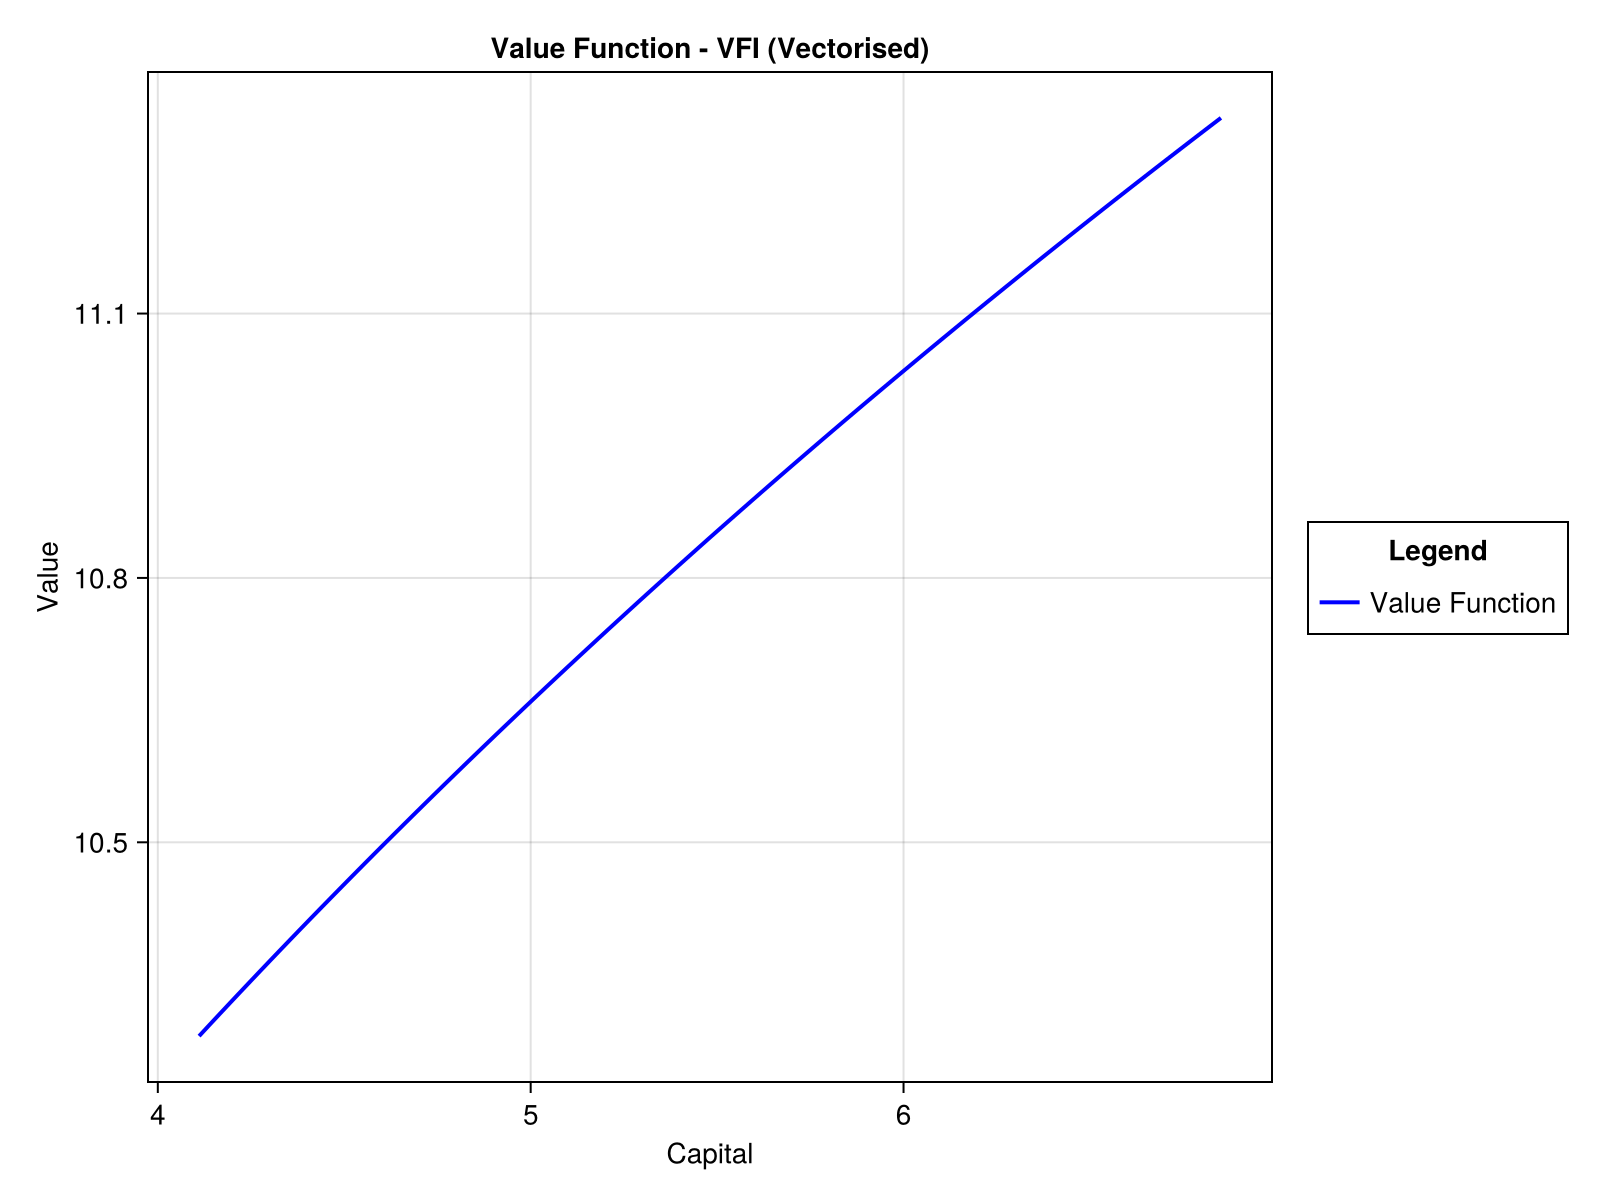

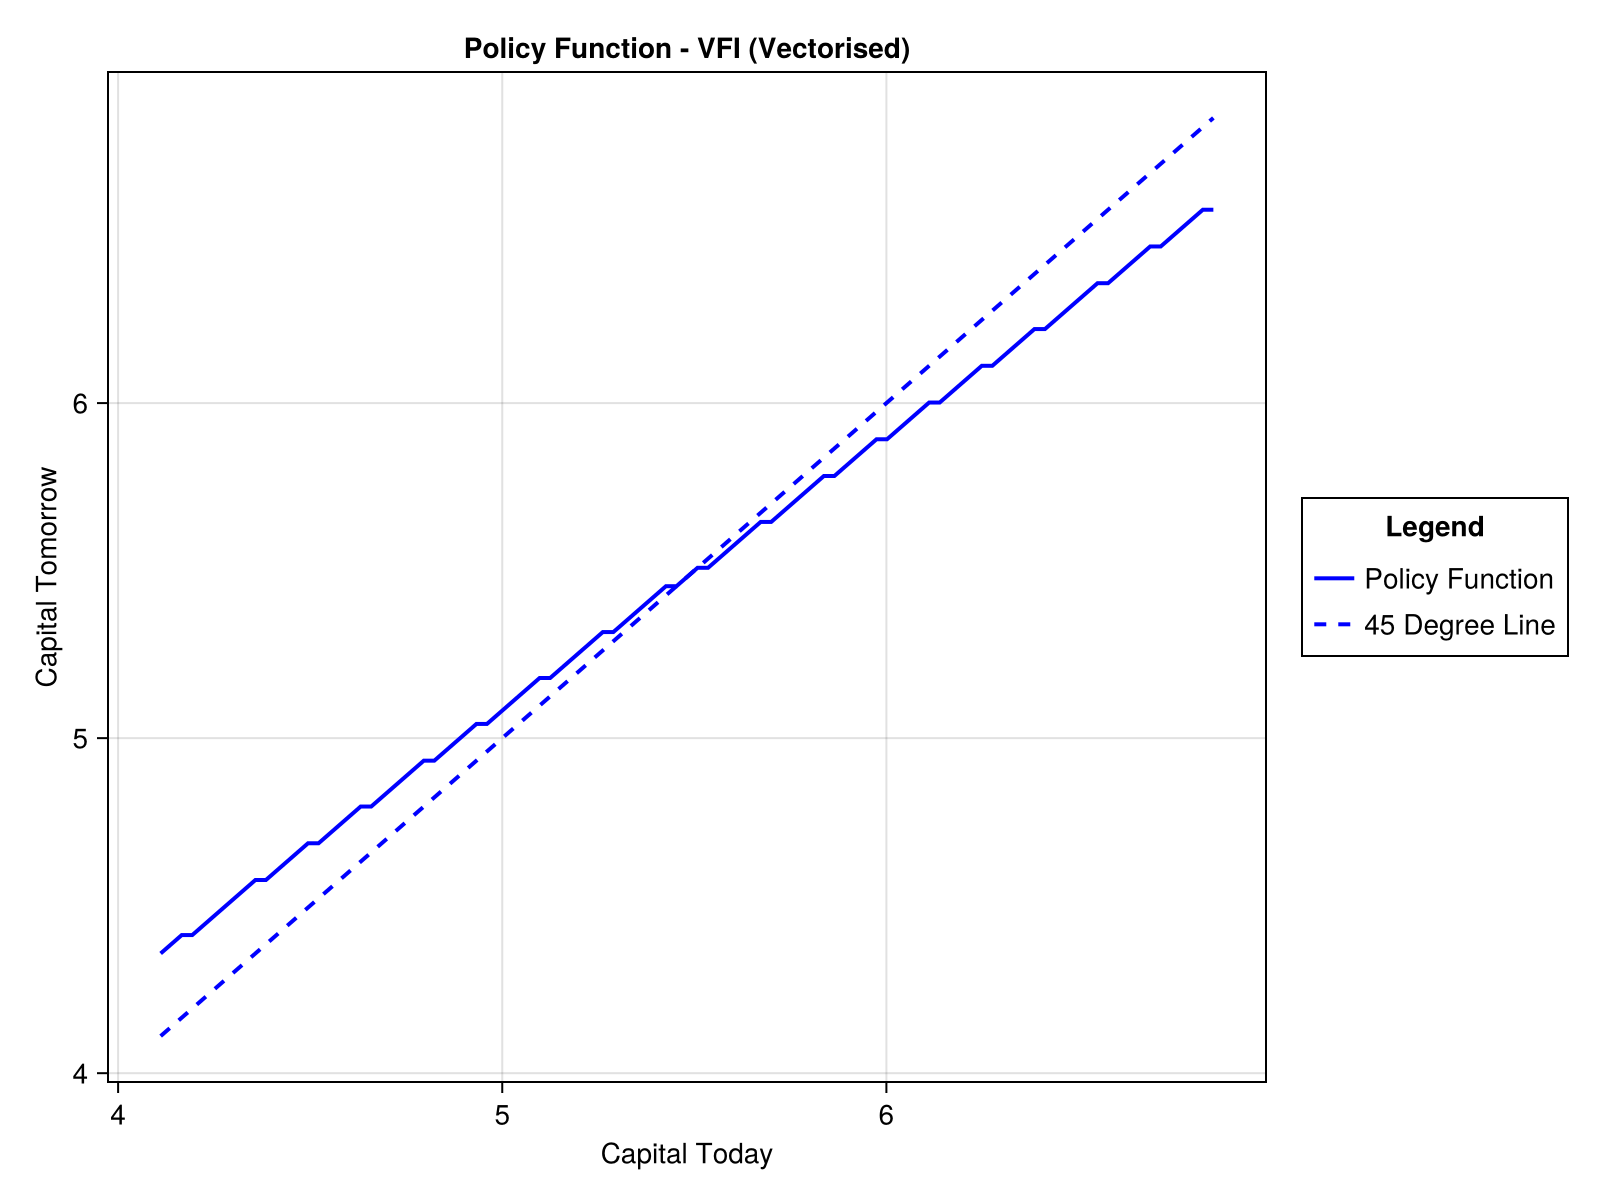

Iterating...
--------------------
iteration 0 completed with error 1.762951428590337
--------------------
converged in 133 iterations
--------------------
  1.268865 seconds (681.08 k allocations: 92.952 MiB, 0.89% gc time, 72.14% compilation time)


(Float32[10.2800865, 10.292588, 10.305016, 10.317384, 10.329702, 10.341964, 10.354178, 10.366338, 10.3784485, 10.390503  …  11.241433, 11.250481, 11.259505, 11.2685, 11.277481, 11.286443, 11.295381, 11.30428, 11.313158, 11.322014], Float32[4.3573465, 4.3847513, 4.412156, 4.412156, 4.439561, 4.4669657, 4.49437, 4.521775, 4.5491796, 4.5765843  …  6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.577127])

In [14]:
function vfi_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_out_nt_vec, pol_out_nt_vec = vfi_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

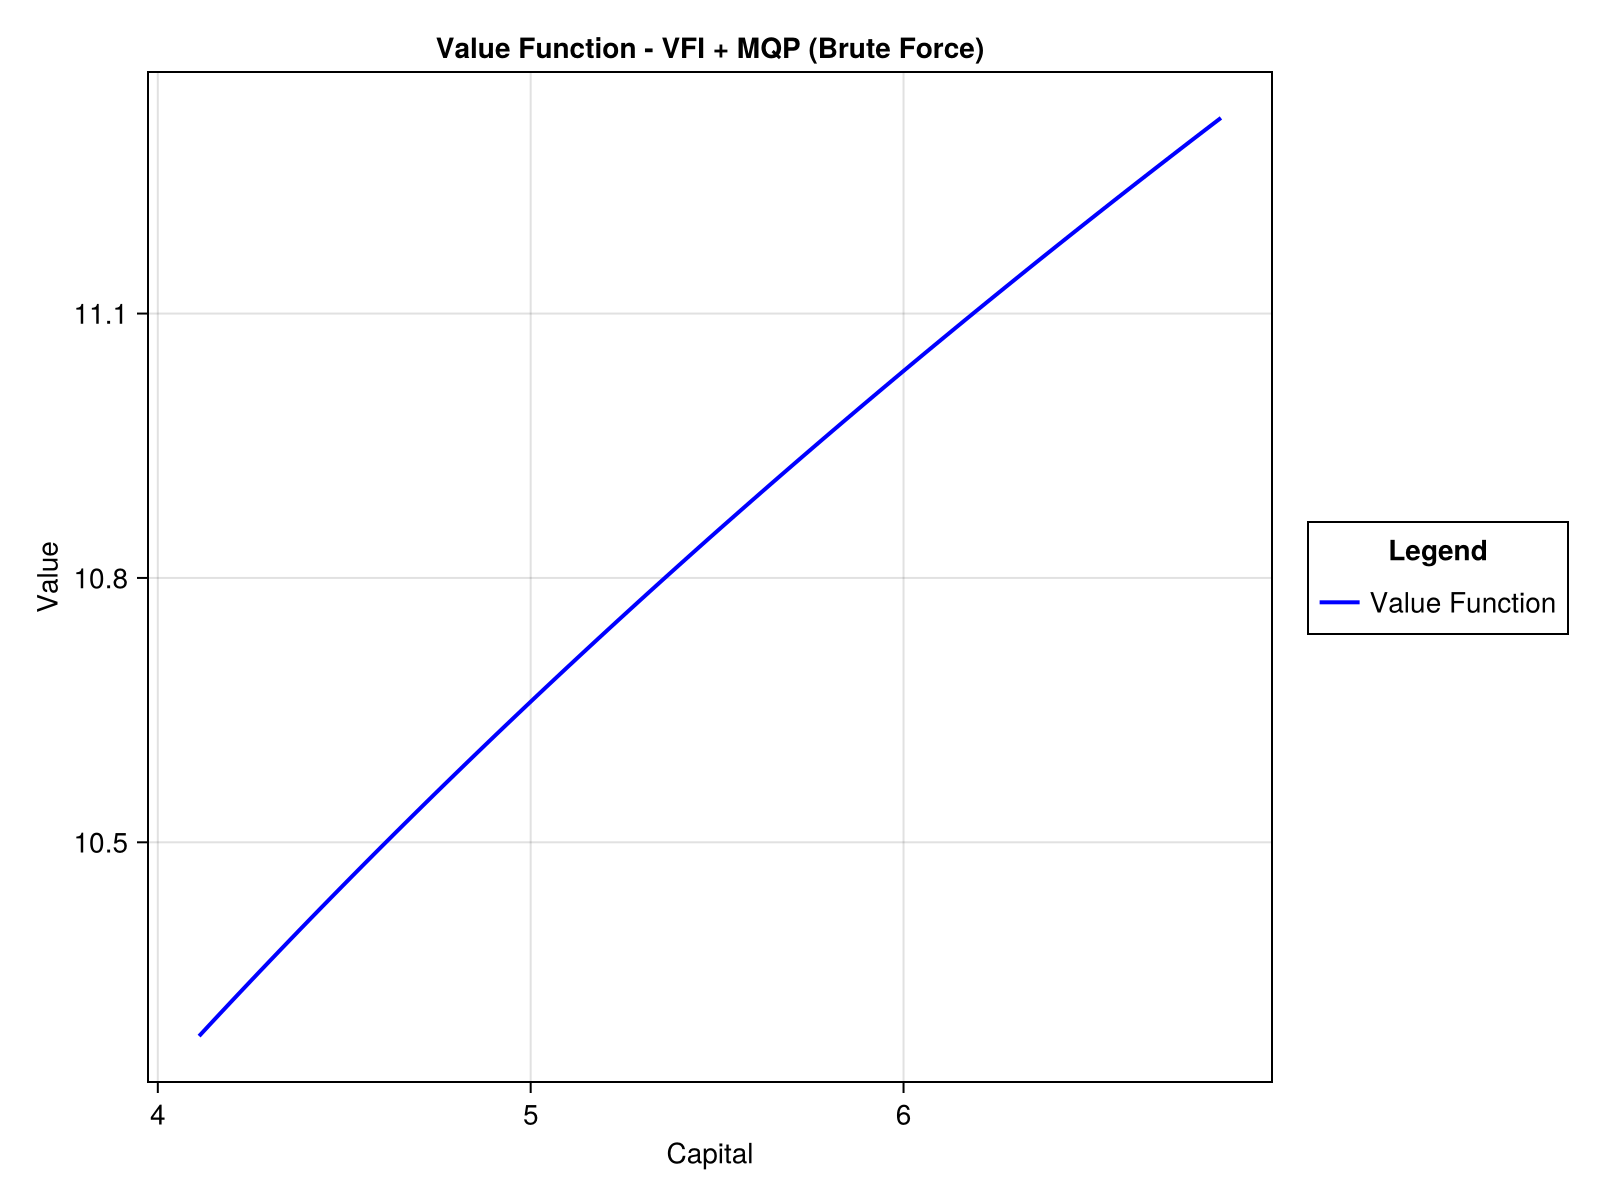

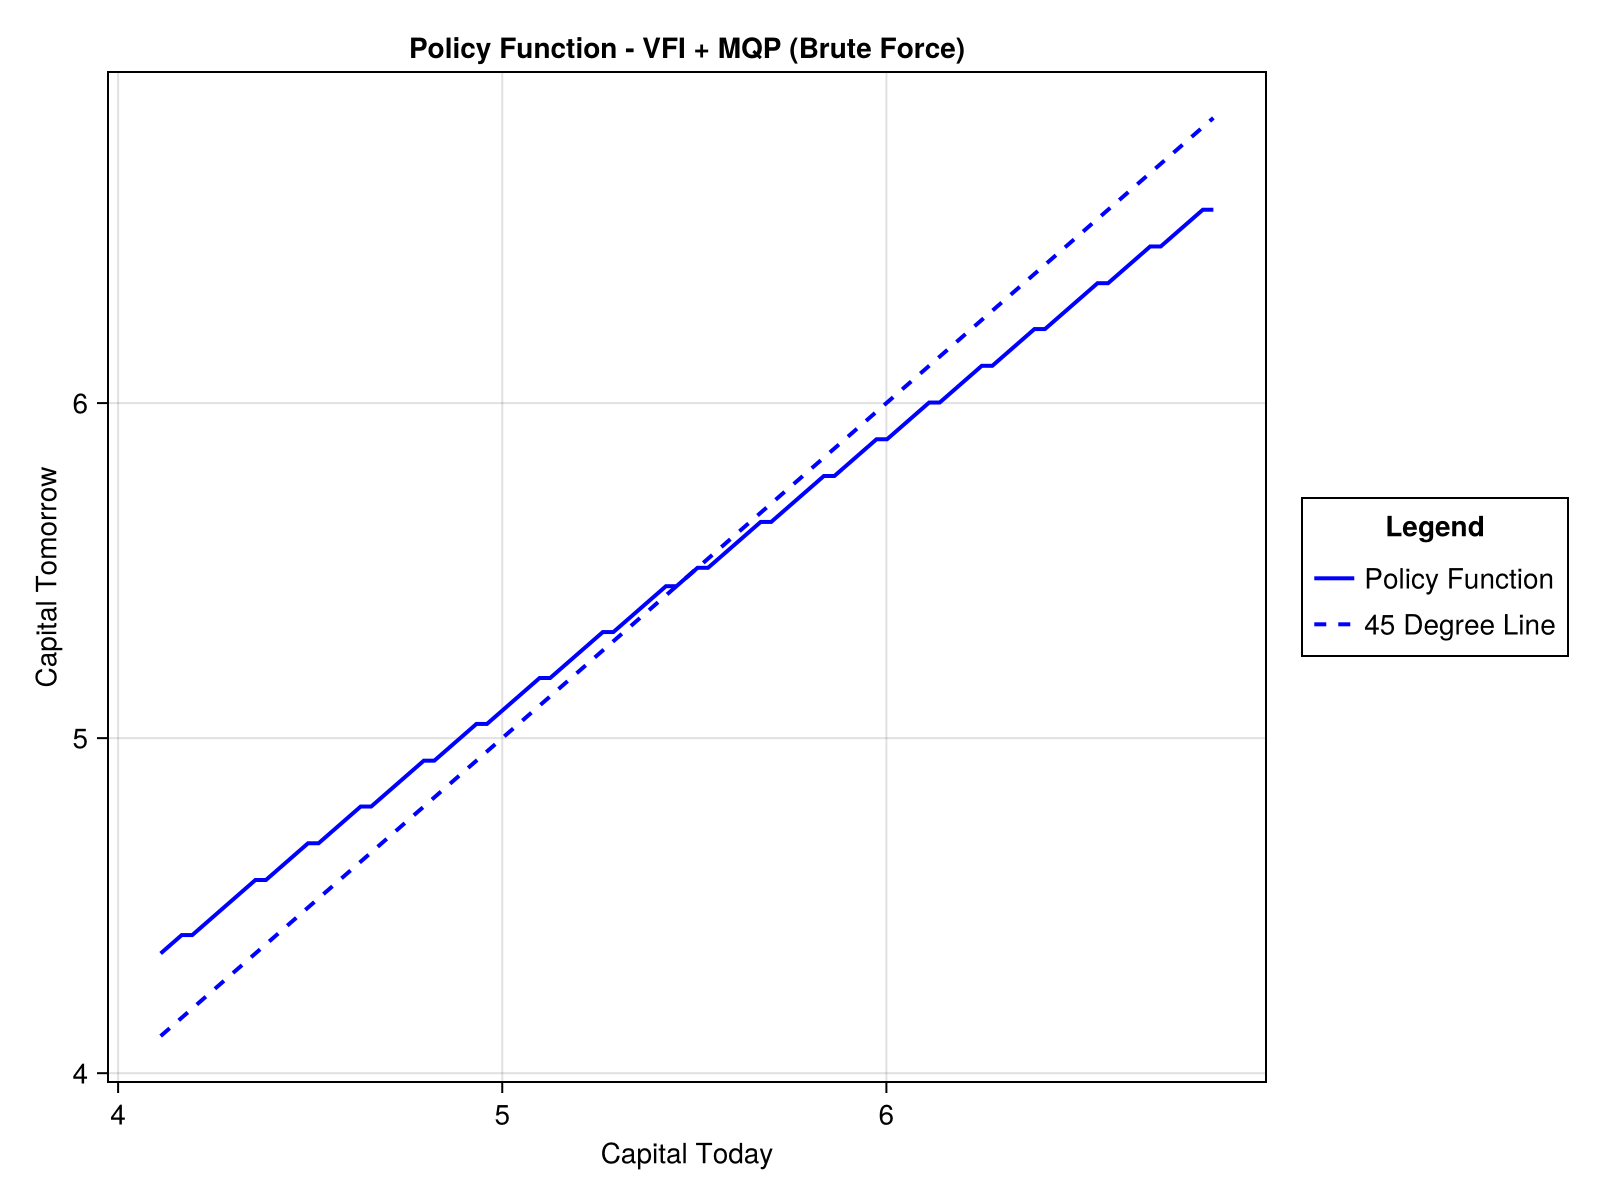

Iterating...
--------------------
iteration 0 completed with error 6.671974964734428
--------------------
converged in 56 iterations
--------------------
  0.979230 seconds (522.08 k allocations: 63.765 MiB, 1.44% gc time, 59.92% compilation time)


(Float32[10.280095, 10.292598, 10.305025, 10.317392, 10.329711, 10.341972, 10.354187, 10.366347, 10.378457, 10.3905115  …  11.241442, 11.250488, 11.259513, 11.268509, 11.277489, 11.28645, 11.295389, 11.304289, 11.313166, 11.3220215], Float32[4.3573465, 4.3847513, 4.412156, 4.412156, 4.439561, 4.4669657, 4.49437, 4.521775, 4.5491796, 4.5765843  …  6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.577127])

In [15]:
function mqp_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        low_bound = minimum(v_new .- v) .* (β / (1 - β))
        high_bound = maximum(v_new .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new) .+ (low_bound + high_bound)/2
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI + MQP (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_mqp_nt, pol_mqp_nt = mqp_nt_brute_force(zeros(pars.grid_size,1), pars)
end 

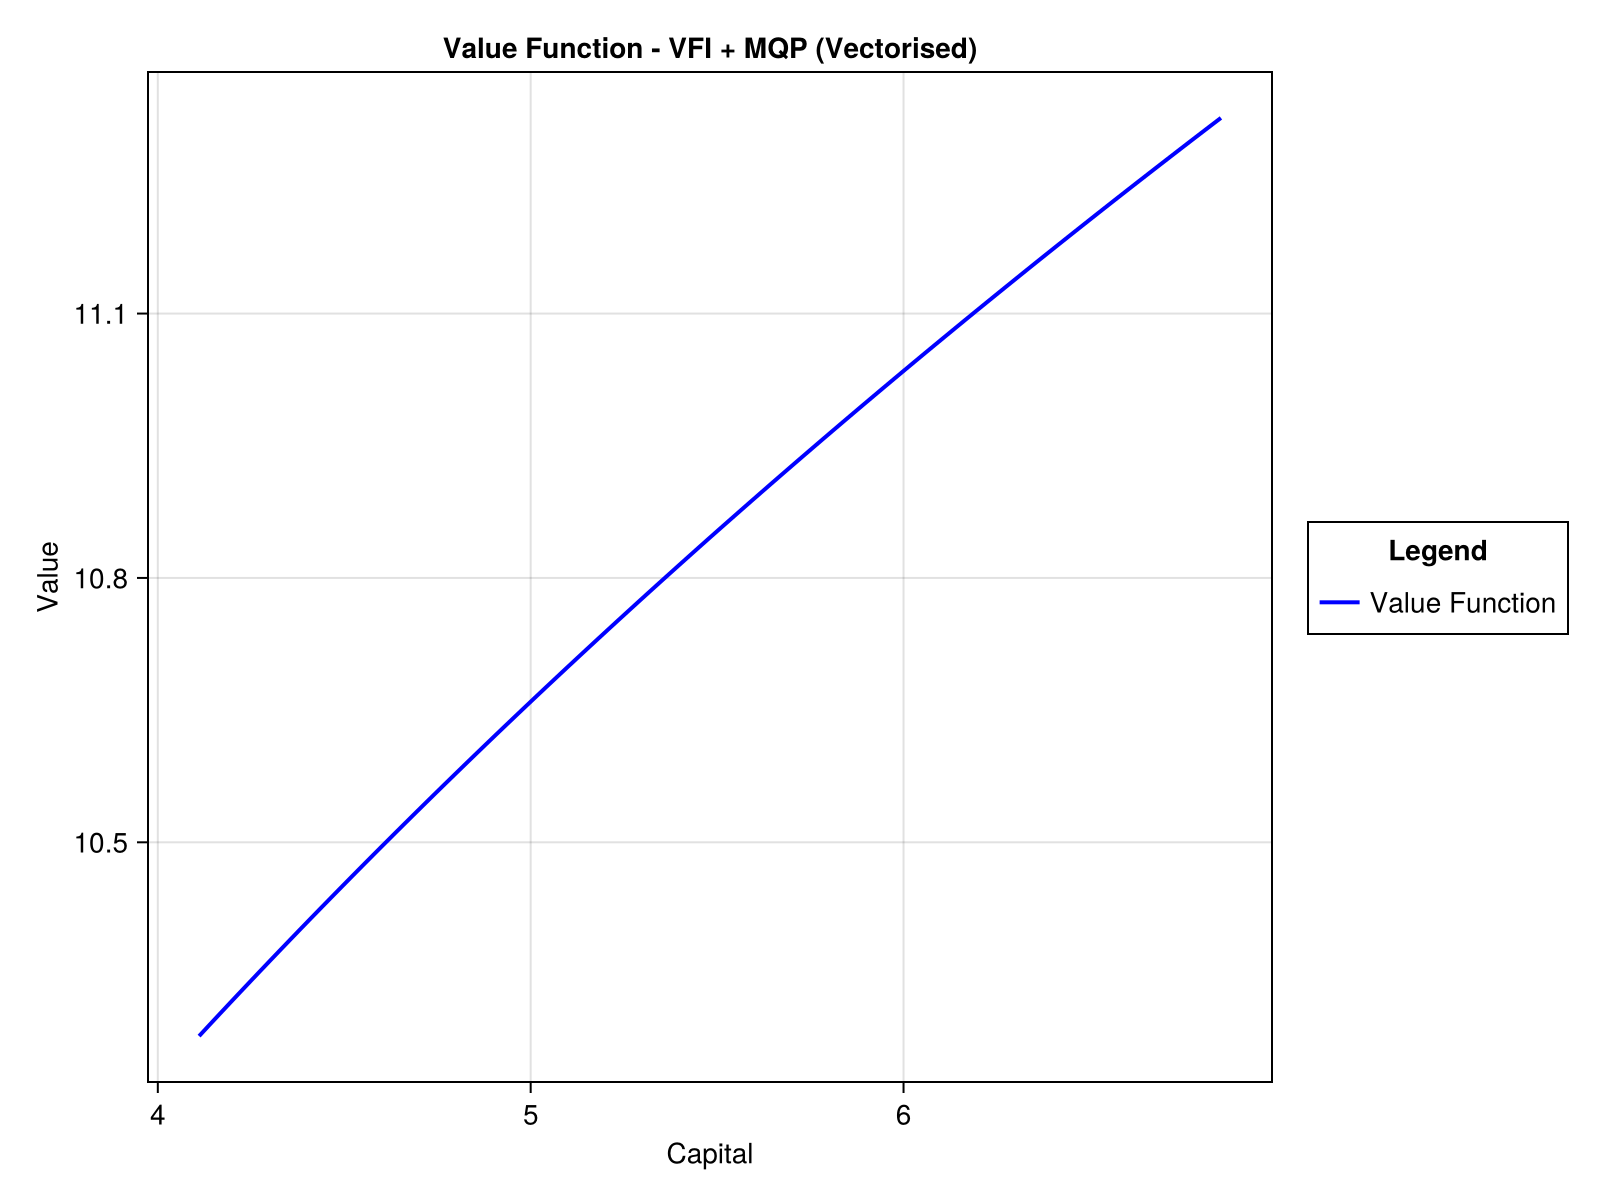

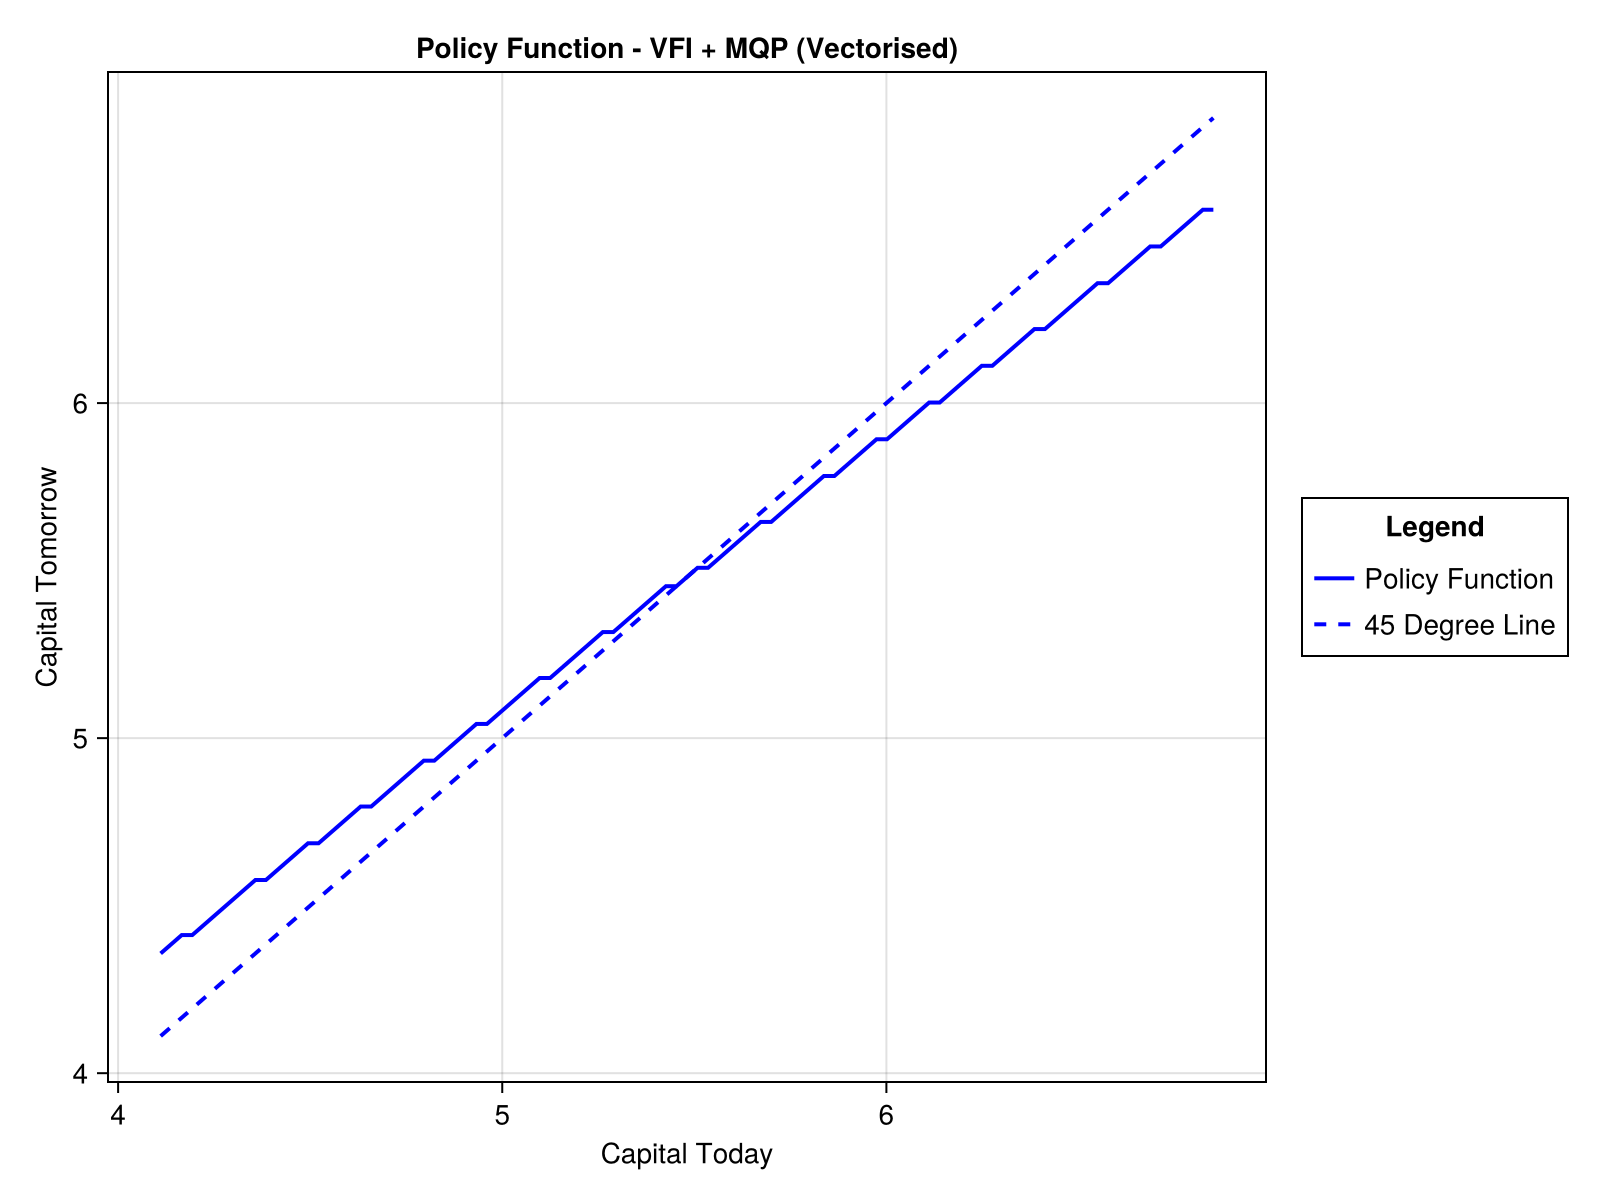

Iterating...
--------------------
iteration 0 completed with error 6.671974964734428
--------------------
converged in 56 iterations
--------------------
  1.371651 seconds (708.97 k allocations: 82.060 MiB, 1.12% gc time, 75.43% compilation time)


(Float32[10.280095, 10.292598, 10.305025, 10.317392, 10.329711, 10.341972, 10.354187, 10.366347, 10.378457, 10.3905115  …  11.241442, 11.250488, 11.259513, 11.268509, 11.277489, 11.28645, 11.295389, 11.304289, 11.313166, 11.3220215], Float32[4.3573465, 4.3847513, 4.412156, 4.412156, 4.439561, 4.4669657, 4.49437, 4.521775, 4.5491796, 4.5765843  …  6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.577127])

In [16]:
function mqp_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        high_bound = maximum(vmax .- v) .* (β / (1 - β))
        low_bound = minimum(vmax .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        v .= vmax .+ (low_bound + high_bound)/2
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI + MQP (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_mqp_nt_vec, pol_mqp_nt_vec = mqp_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

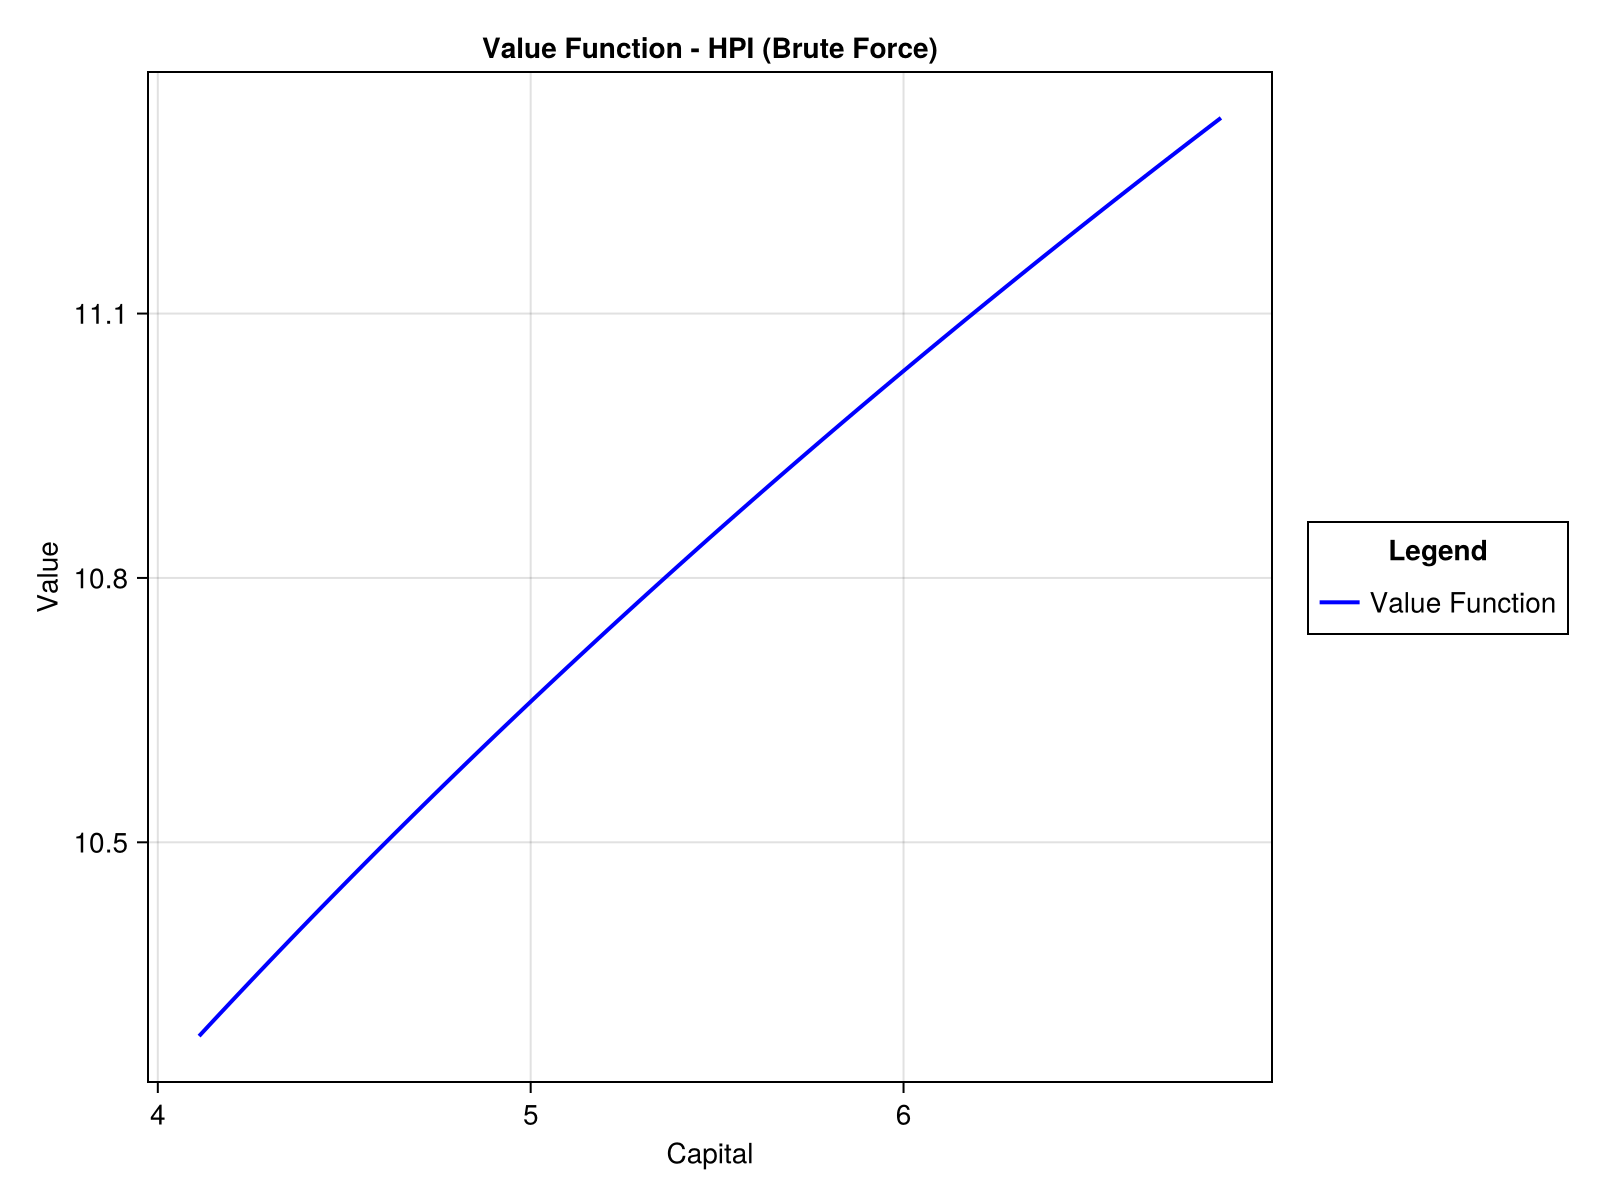

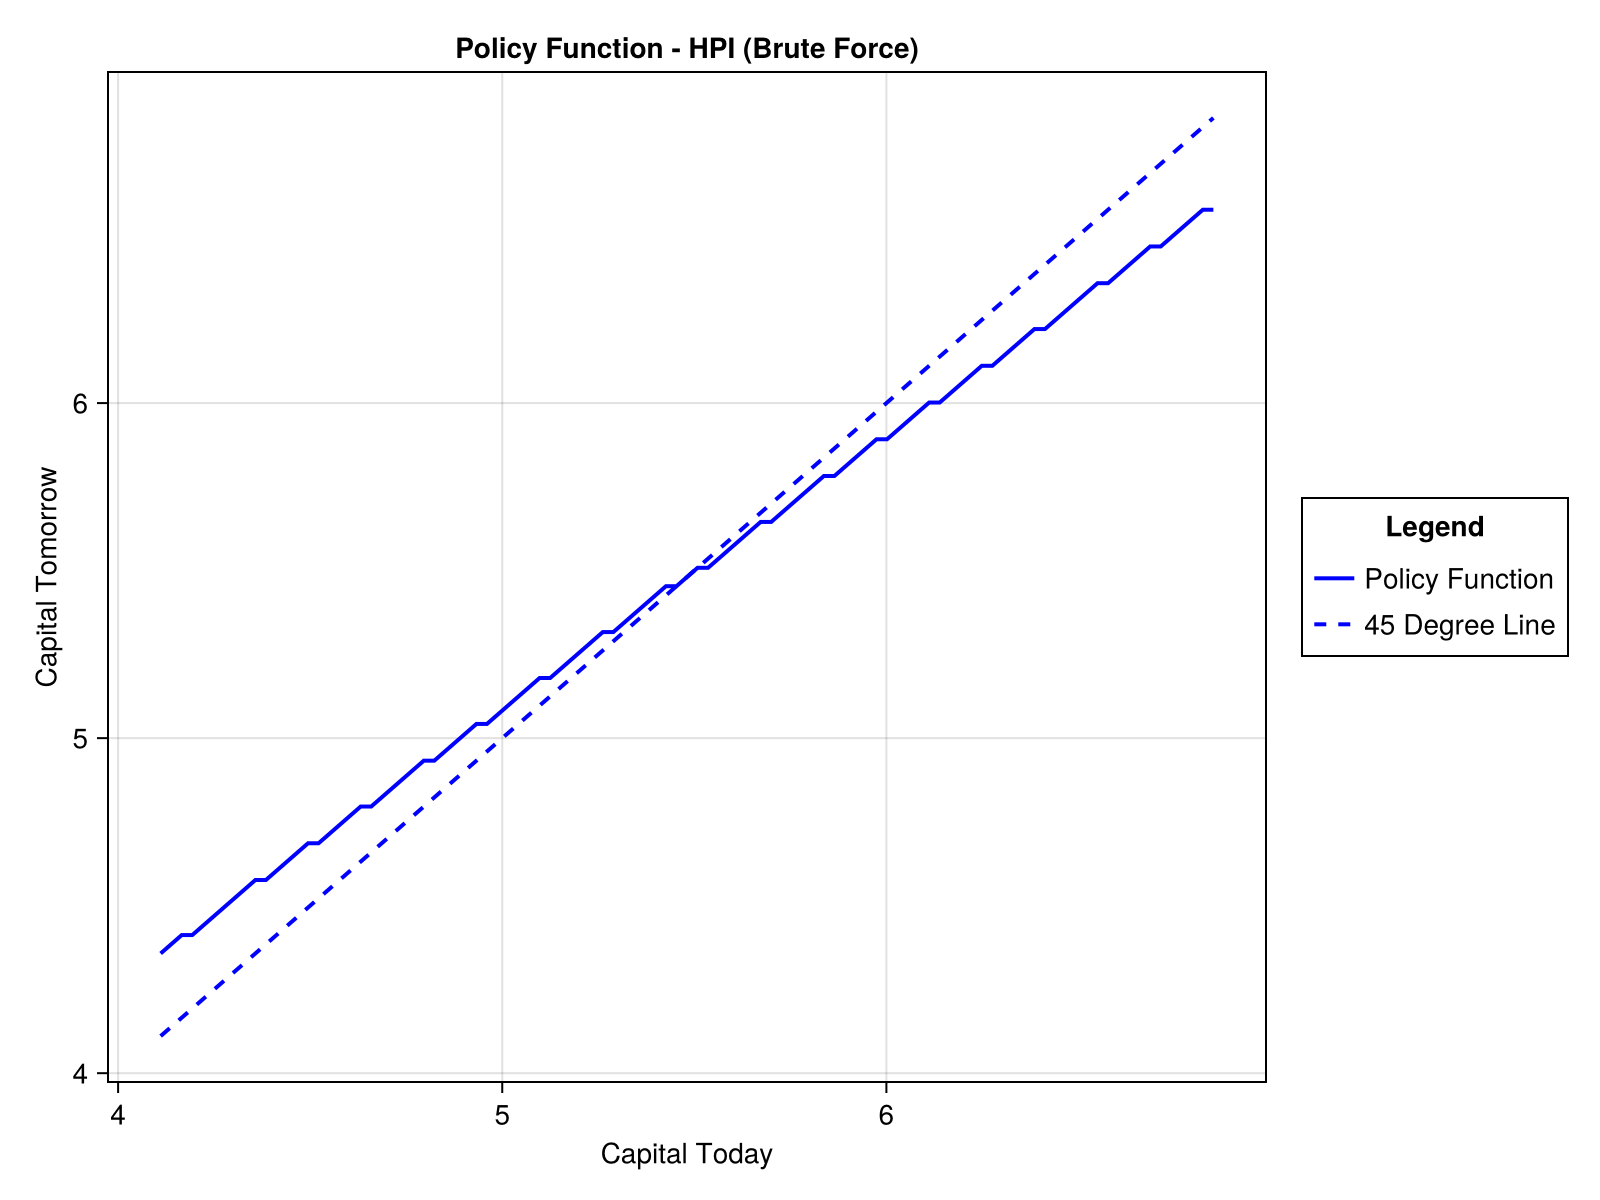

Iterating...
--------------------
iteration 0 completed with error 10.95729510005233
--------------------
converged in 13 iterations
--------------------
  0.906979 seconds (434.14 k allocations: 58.637 MiB, 1.51% gc time, 63.22% compilation time)


(Float32[10.280095, 10.292597, 10.305024, 10.317391, 10.329711, 10.341972, 10.354187, 10.366346, 10.378457, 10.3905115  …  11.241442, 11.250488, 11.259514, 11.268509, 11.27749, 11.286451, 11.295389, 11.304289, 11.313167, 11.322022], Float32[4.3573465, 4.3847513, 4.412156, 4.412156, 4.439561, 4.4669657, 4.49437, 4.521775, 4.5491796, 4.5765843  …  6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.577127])

In [17]:
function howard_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler, m) = pars
    v_new = similar(v)
    v2 = similar(v)
    policy = similar(v)
    idx = zeros(Int, grid_size,1)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                        idx[i] = j
                    end
                end
            end
            v_new[i] = vmax
        end
        for _ in 1:m
            for i in 1:grid_size
                j = idx[i]
                c = A*kgrid[i]^α + (1.0-δ) * kgrid[i] - policy[i]
                v2[i] = utility(c, pars) + β * v_new[j]
            end  
            v_new .= copy(v2)    
        end
        error = maximum(v_new .- v)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - HPI (Brute Force)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - HPI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_howard_nt, pol_howard_nt = howard_nt_brute_force(zeros(pars.grid_size,1), pars)
end

# Work in progress from this point forwards

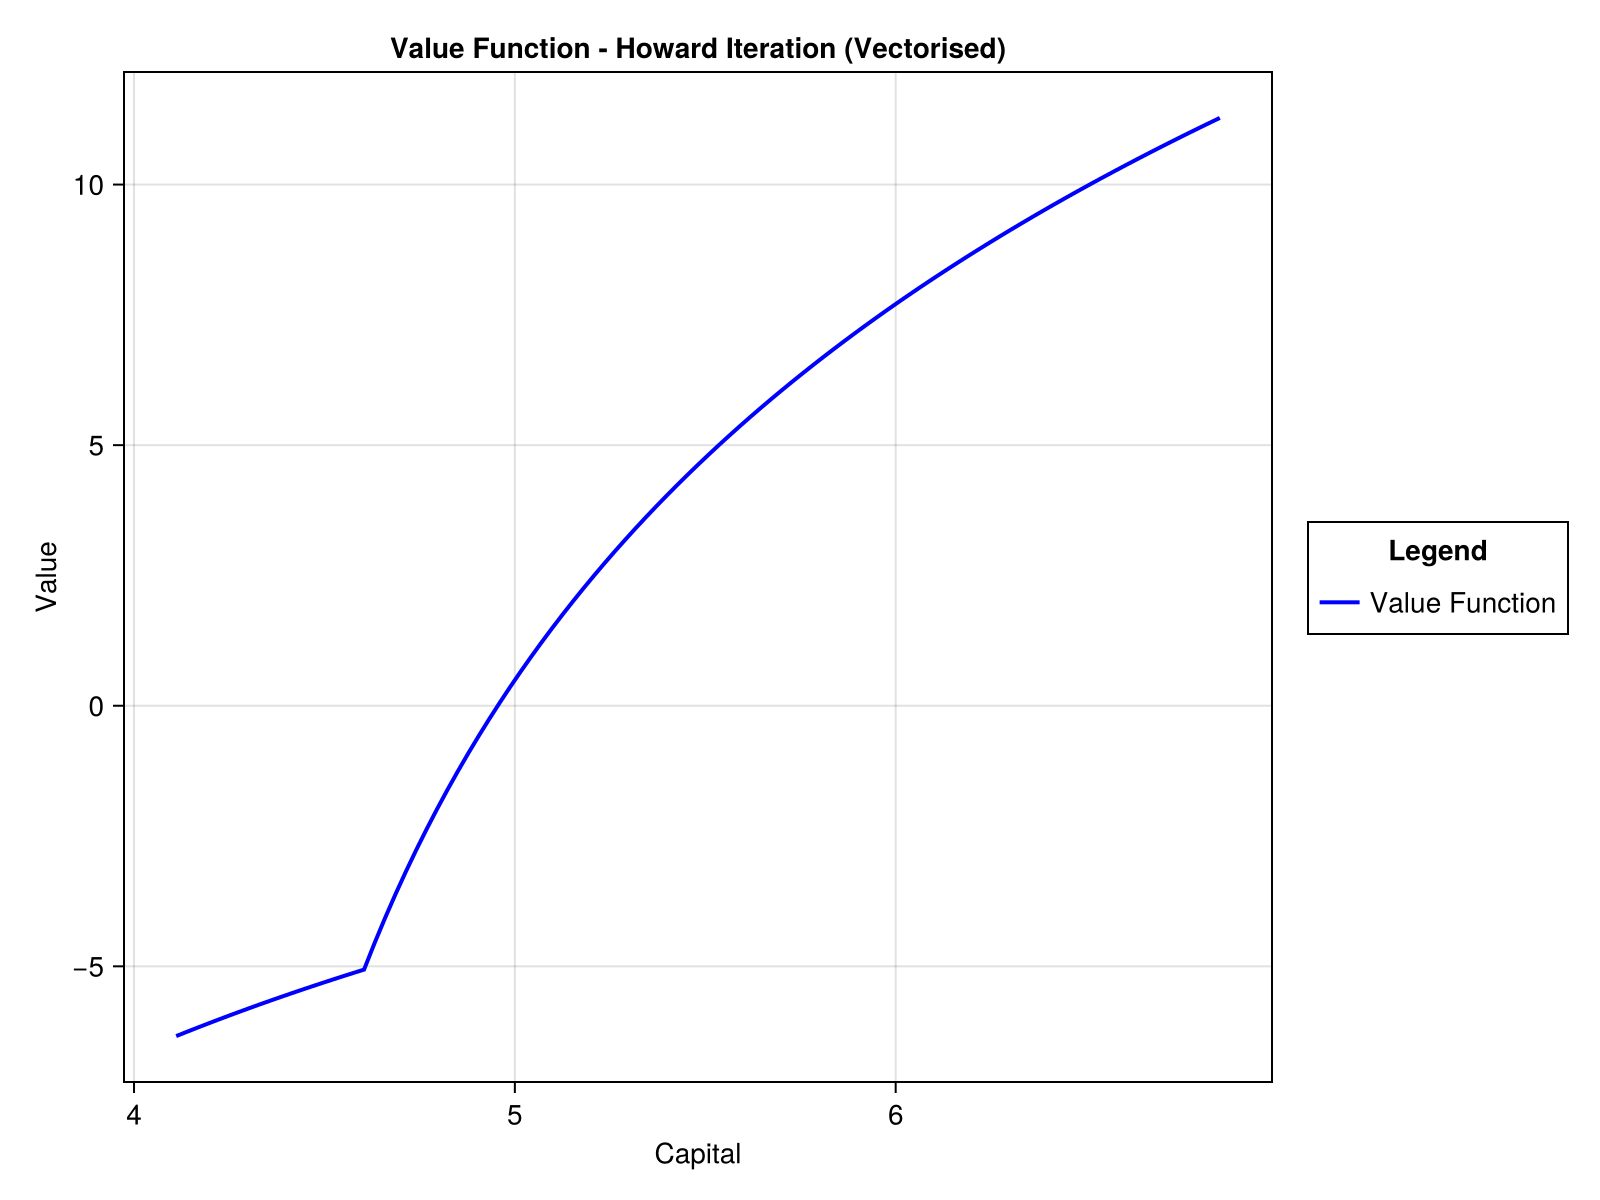

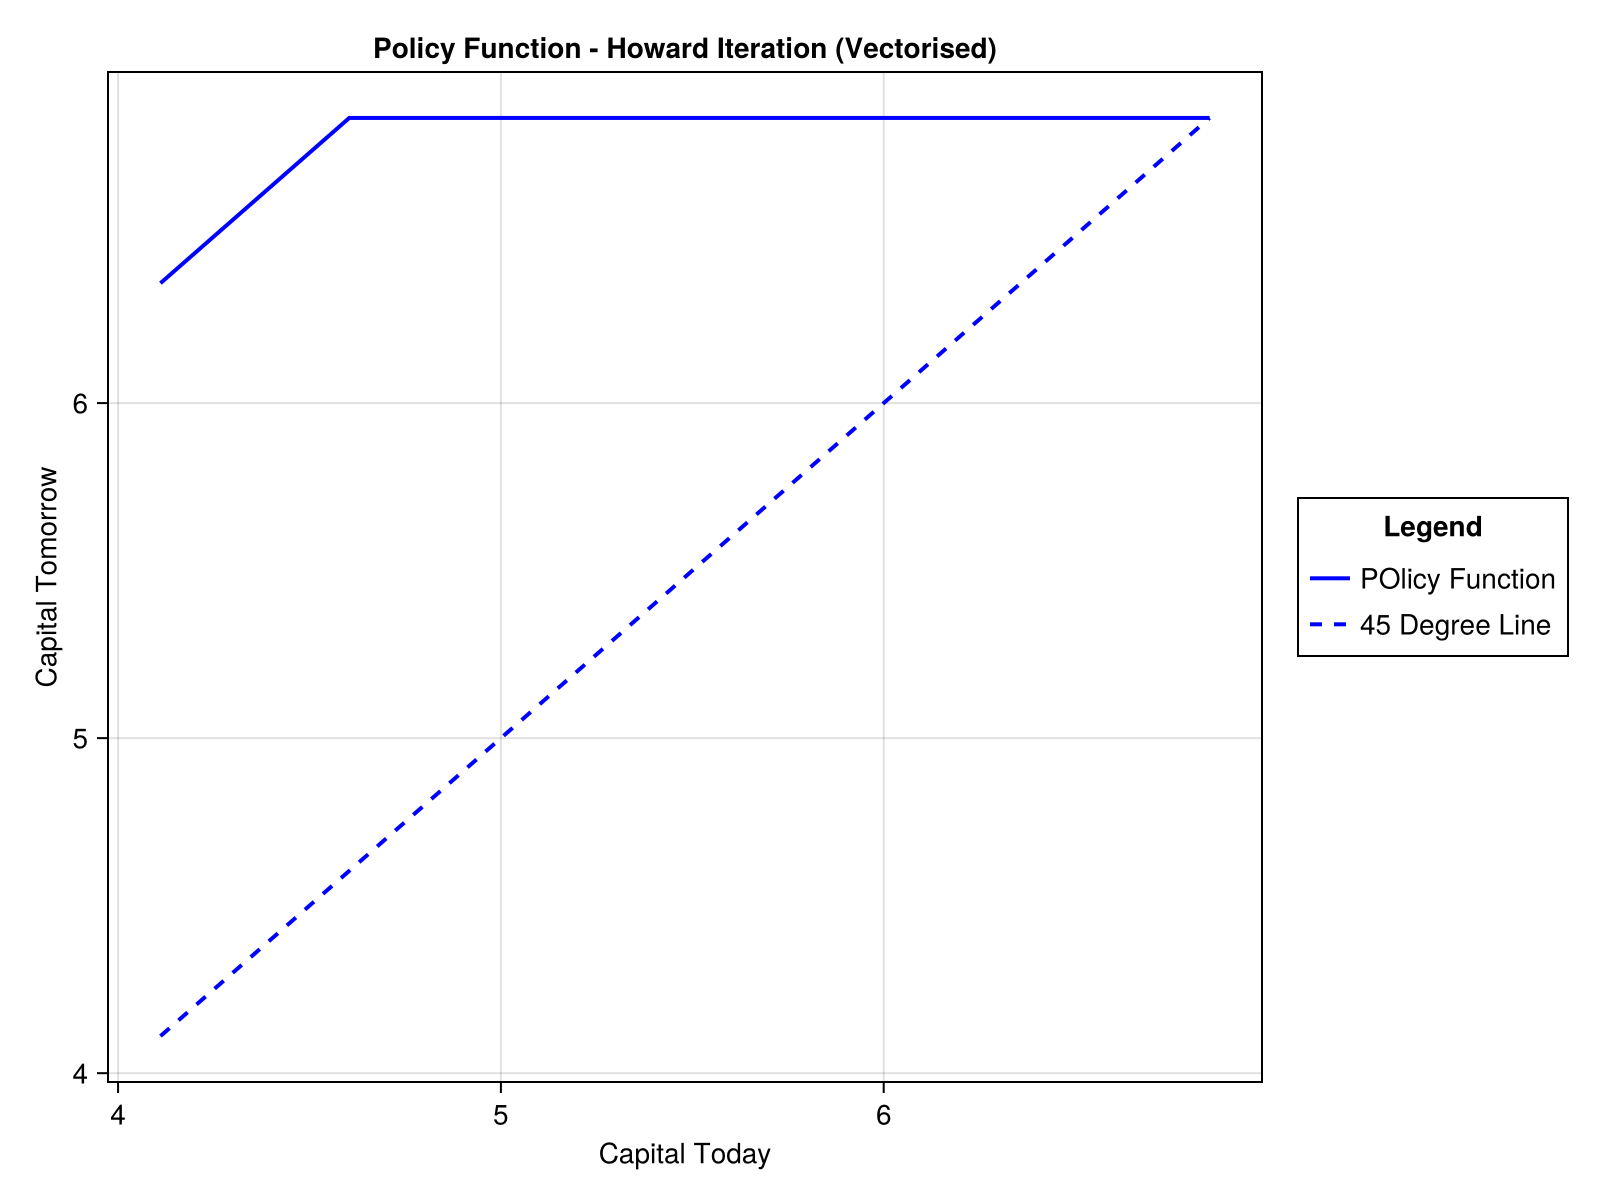

Iterating...
--------------------
iteration 0 completed with error 17.629092847798344
--------------------
converged in 2 iterations
--------------------
  2.297236 seconds (2.16 M allocations: 170.938 MiB, 2.12% gc time, 84.97% compilation time)


(Float32[-6.3386464, -6.2586827, -6.179928, -6.102352, -6.025928, -5.9506273, -5.876423, -5.80329, -5.7312026, -5.660137  …  10.373852, 10.478773, 10.582557, 10.6852255, 10.786803, 10.887314, 10.986777, 11.085217, 11.182653, 11.279105], Float32[6.3578897, 6.3852944, 6.4126987, 6.4401035, 6.4675083, 6.494913, 6.522318, 6.5497227, 6.577127, 6.604532  …  6.851174, 6.851174, 6.851174, 6.851174, 6.851174, 6.851174, 6.851174, 6.851174, 6.851174, 6.851174])

In [18]:
function howard_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_min, grid_max, grid_size, maxiter, toler, m) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    vmax = similar(v)
    v_howard = similar(v)
    c_howard = similar(v)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    kgrid = reshape(kgrid, (grid_size,1))
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    util = similar(cons)
    util_howard = similar(v)
    util[.!c_pos] .= -Inf
    util[c_pos] = utility_vec(cons[c_pos], pars)
    while ((error > toler) && (iter < maxiter))
        v_new = util .+ β.*transpose(v)
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]]
        for _ in 1:m
            new_c = A .* kgrid.^α .+ (1.0-δ) .* kgrid .- policy
            c_pos_howard = new_c .> 0
            util_howard[.!c_pos_howard] .= -Inf
            util_howard[c_pos_howard] = utility_vec(new_c[c_pos_howard], pars)
            v_howard = util_howard .+ β .* vmax
            vmax .= v_howard
        end
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")

    kgrid = vec(Float32.(kgrid))
    v = vec(Float32.(v))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - Howard Iteration (Vectorised)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, kgrid, v, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    kgrid = vec(Float32.(kgrid))
    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - Howard Iteration (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, kgrid, policy, color = :blue, linewidth = 2, label = "POlicy Function")
    lines!(ax2, kgrid, kgrid, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)
    return v, policy
end

@time begin
    v_howard_nt_vec, pol_howard_nt_vec = howard_nt_vectorised(zeros(pars.grid_size,1), pars)
end